Loading data...
✓ Stock data: 1796 rows
✓ Emotion data: 2268 rows

Aggregating emotions by time windows...
  5min: 171765 time periods
  15min: 57256 time periods
  1H: 14314 time periods

Aggregating stock data by time windows...
  5min: 855 time periods
  15min: 286 time periods
  1H: 72 time periods

Merging emotions with stock data...
  5min: 41 overlapping time periods
  15min: 31 overlapping time periods
  1H: 14 overlapping time periods

CORRELATION ANALYSIS

Analyzing 31 15-minute periods
Date range: 2023-03-07 15:00:00 to 2023-03-10 13:30:00

TOP EMOTIONS CORRELATED WITH RETURNS
confusion      0.342699
curiosity      0.243173
approval       0.163520
realization    0.156148
love           0.128772
fear           0.124740
desire         0.123692
disgust        0.106385
excitement     0.095588
optimism       0.084763
dtype: float64

TOP EMOTIONS CORRELATED WITH VOLATILITY
sadness           0.208155
grief             0.201853
caring            0.149873
remorse           0.087208
c

/var/folders/65/5x_y6d7d0h9fyf4fnb4ytp680000gn/T/ipykernel_10951/1269333686.py:57: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  agg = all_emotions[emotion_cols].resample(window).agg(['mean', 'count'])
/var/folders/65/5x_y6d7d0h9fyf4fnb4ytp680000gn/T/ipykernel_10951/1269333686.py:81: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  agg['returns'] = agg['Close'].pct_change()
/var/folders/65/5x_y6d7d0h9fyf4fnb4ytp680000gn/T/ipykernel_10951/1269333686.py:81: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  agg['returns'] = agg['Close'].pct_change()
/v

✓ Saved: emotion_market_correlations.png
✓ Saved: emotion_timeseries.png

LAG ANALYSIS - Do emotions predict market moves?

Emotions that PREDICT next period returns:
approval         0.433917
realization      0.359376
embarrassment    0.264282
disgust          0.258324
surprise         0.256208
optimism         0.251631
amusement        0.247489
desire           0.214730
fear             0.205098
excitement       0.204677
dtype: float64

Emotions that ANTI-PREDICT next period returns:
nervousness    0.127619
joy            0.124238
relief         0.109213
anger          0.023634
disapproval   -0.081388
remorse       -0.257012
sadness       -0.326364
gratitude     -0.334876
grief         -0.336385
caring        -0.432196
dtype: float64

✓ Saved: emotion_market_correlations.csv
✓ Saved: emotion_lag_correlations.csv
✓ Saved: svb_merged_emotions_stock.csv

ANALYSIS COMPLETE!

Files created:
  - emotion_market_correlations.png
  - emotion_timeseries.png
  - emotion_market_correlations.csv


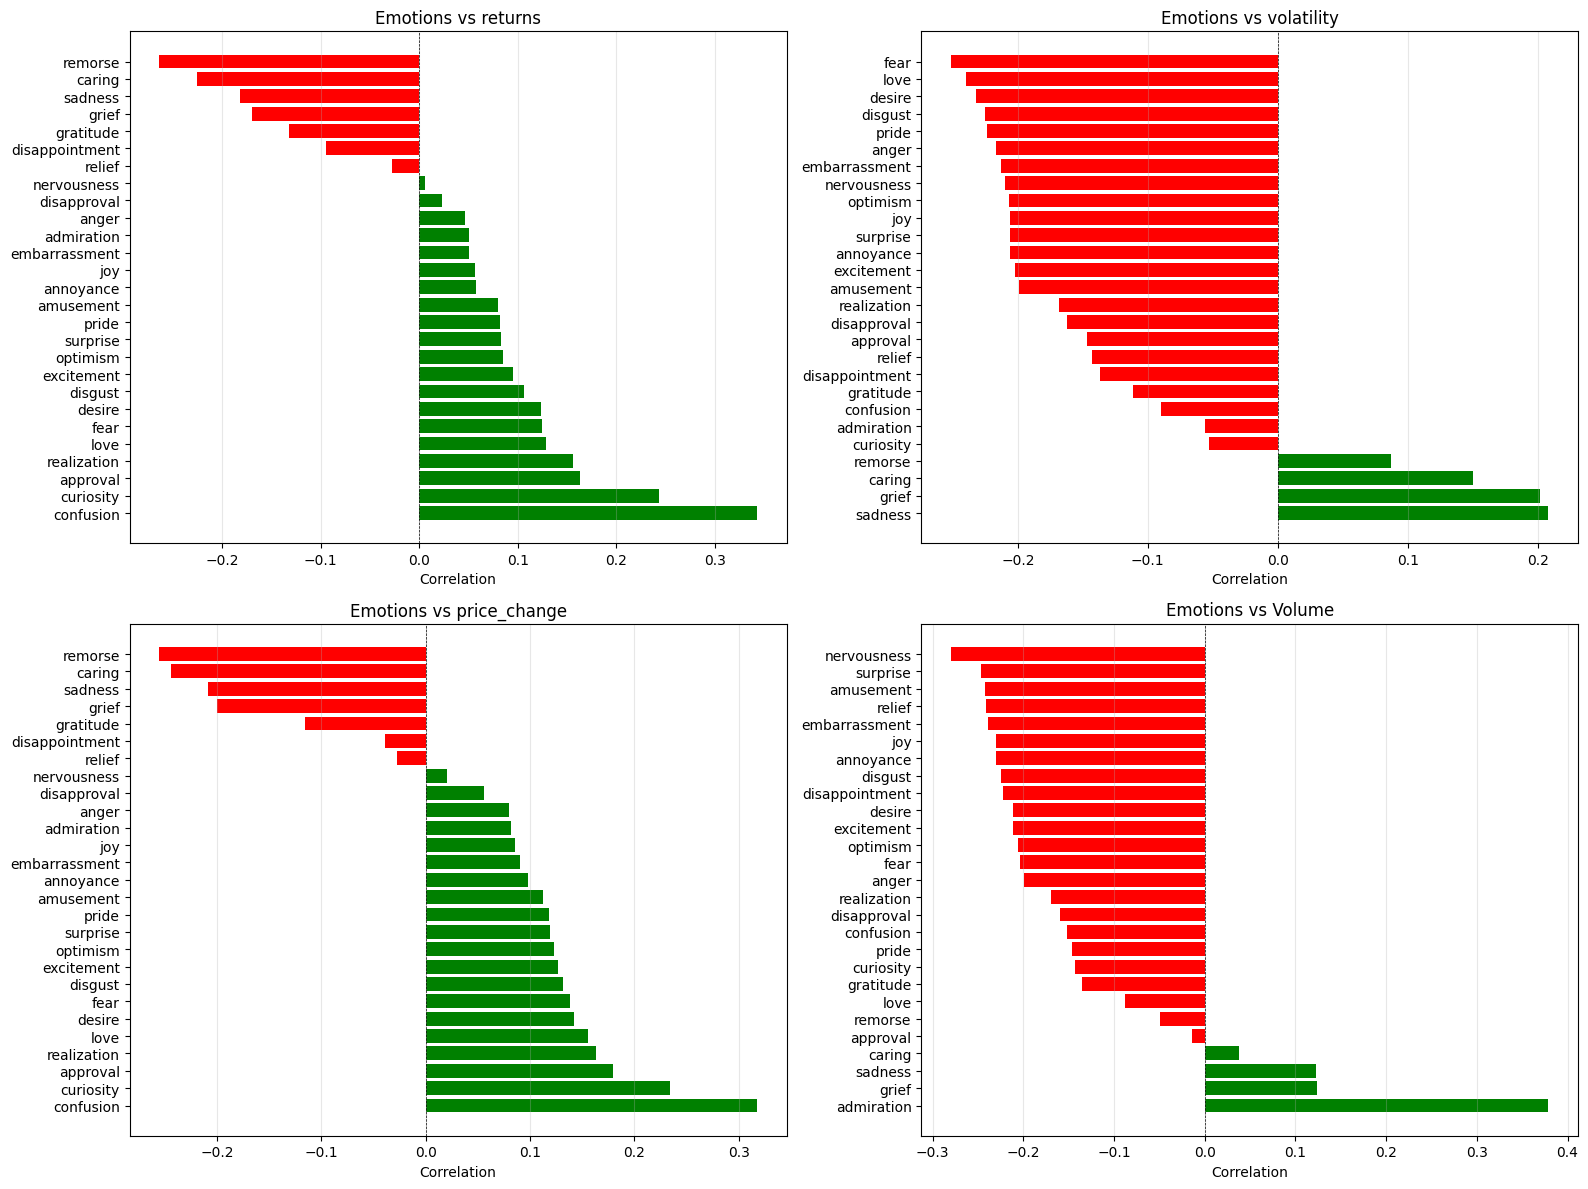

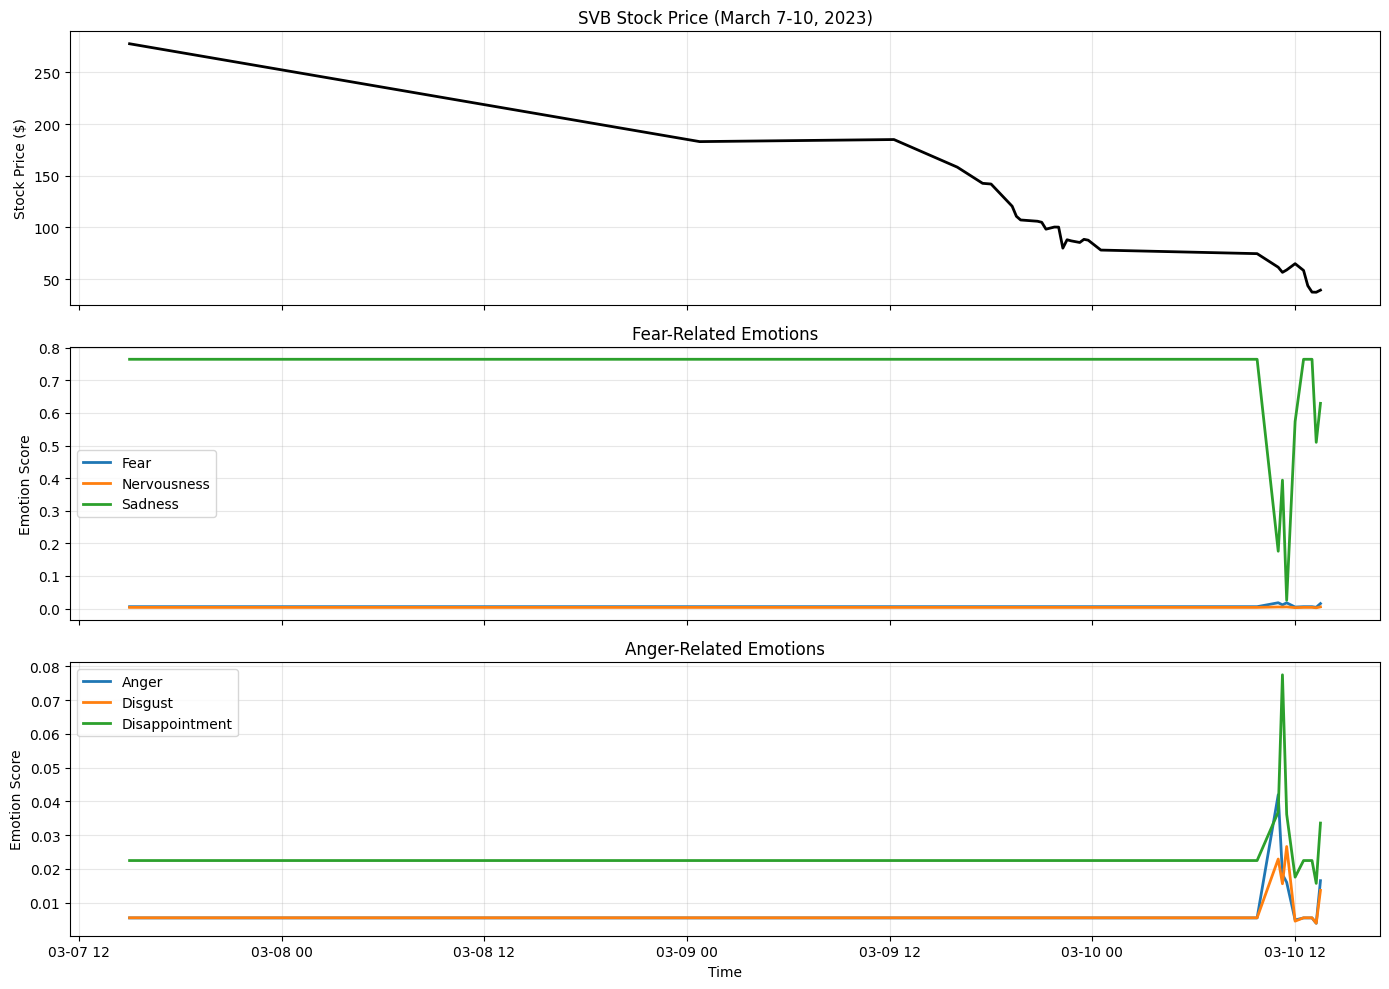

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from datetime import datetime, timedelta

# ============================================
# STEP 1: Load all data
# ============================================

print("Loading data...")

# Load stock data
stock_df = pd.read_csv('svb_minute_data.csv')  # Or whatever you named it
stock_df['timestamp'] = pd.to_datetime(stock_df['timestamp'])

# Load emotion data
posts_emotions = pd.read_csv('/Users/carolinerennier/Desktop/svb_posts_with_emotion.csv')
comments_emotions = pd.read_csv('/Users/carolinerennier/Desktop/svb_comments_with_emotion.csv')

# Combine posts and comments
posts_emotions['timestamp'] = pd.to_datetime(posts_emotions['timestamp'])
comments_emotions['timestamp'] = pd.to_datetime(comments_emotions['timestamp'])

all_emotions = pd.concat([posts_emotions, comments_emotions], ignore_index=True)

print(f"✓ Stock data: {len(stock_df)} rows")
print(f"✓ Emotion data: {len(all_emotions)} rows")

# ============================================
# STEP 2: Define emotion columns (excluding neutral)
# ============================================

emotion_cols = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 
    'caring', 'confusion', 'curiosity', 'desire', 'disappointment',
    'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
    'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism',
    'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise'
]

# ============================================
# STEP 3: Aggregate emotions by time windows
# ============================================

print("\nAggregating emotions by time windows...")

# Set timestamp as index
all_emotions = all_emotions.set_index('timestamp')

# Resample to different time windows
time_windows = ['5min', '15min', '1H']

emotion_aggregated = {}

for window in time_windows:
    agg = all_emotions[emotion_cols].resample(window).agg(['mean', 'count'])
    emotion_aggregated[window] = agg
    print(f"  {window}: {len(agg)} time periods")

# ============================================
# STEP 4: Aggregate stock data by same windows
# ============================================

print("\nAggregating stock data by time windows...")

stock_df = stock_df.set_index('timestamp')

stock_aggregated = {}

for window in time_windows:
    agg = stock_df.resample(window).agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    })
    
    # Calculate returns and volatility
    agg['returns'] = agg['Close'].pct_change()
    agg['volatility'] = agg['Close'].rolling(window=3).std()
    agg['price_change'] = agg['Close'].diff()
    
    stock_aggregated[window] = agg
    print(f"  {window}: {len(agg)} time periods")

# ============================================
# STEP 5: Merge emotions with stock data
# ============================================

print("\nMerging emotions with stock data...")

merged_data = {}

for window in time_windows:
    # Get emotion means
    emotion_means = emotion_aggregated[window].xs('mean', axis=1, level=1)
    
    # Merge with stock data
    merged = stock_aggregated[window].join(emotion_means, how='inner')
    merged = merged.dropna()
    
    merged_data[window] = merged
    print(f"  {window}: {len(merged)} overlapping time periods")

# ============================================
# STEP 6: Calculate correlations
# ============================================

print("\n" + "="*60)
print("CORRELATION ANALYSIS")
print("="*60)

# Use 15-minute window as primary analysis
df = merged_data['15min']

print(f"\nAnalyzing {len(df)} 15-minute periods")
print(f"Date range: {df.index.min()} to {df.index.max()}")

# Calculate correlations between emotions and market metrics
market_metrics = ['returns', 'volatility', 'price_change', 'Volume']

correlations = {}

for metric in market_metrics:
    corrs = df[emotion_cols].corrwith(df[metric]).sort_values(ascending=False)
    correlations[metric] = corrs
    
    print(f"\n{'='*60}")
    print(f"TOP EMOTIONS CORRELATED WITH {metric.upper()}")
    print(f"{'='*60}")
    print(corrs.head(10))

# ============================================
# STEP 7: Visualize correlations
# ============================================

print("\nCreating visualizations...")

# Heatmap of all correlations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, metric in enumerate(market_metrics):
    ax = axes[idx // 2, idx % 2]
    
    corr_df = pd.DataFrame({
        'Emotion': correlations[metric].index,
        'Correlation': correlations[metric].values
    })
    
    # Sort and plot
    corr_df = corr_df.sort_values('Correlation', ascending=False)
    
    colors = ['red' if x < 0 else 'green' for x in corr_df['Correlation']]
    ax.barh(corr_df['Emotion'], corr_df['Correlation'], color=colors)
    ax.set_xlabel('Correlation')
    ax.set_title(f'Emotions vs {metric}')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('emotion_market_correlations.png', dpi=300, bbox_inches='tight')
print("✓ Saved: emotion_market_correlations.png")

# ============================================
# STEP 8: Time series plots
# ============================================

# Plot key emotions over time with stock price
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Plot 1: Stock price
axes[0].plot(df.index, df['Close'], color='black', linewidth=2)
axes[0].set_ylabel('Stock Price ($)')
axes[0].set_title('SVB Stock Price (March 7-10, 2023)')
axes[0].grid(alpha=0.3)

# Plot 2: Fear + Nervousness + Sadness
fear_emotions = ['fear', 'nervousness', 'sadness']
for emotion in fear_emotions:
    if emotion in df.columns:
        axes[1].plot(df.index, df[emotion], label=emotion.capitalize(), linewidth=2)
axes[1].set_ylabel('Emotion Score')
axes[1].set_title('Fear-Related Emotions')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Plot 3: Anger + Disgust + Disappointment
anger_emotions = ['anger', 'disgust', 'disappointment']
for emotion in anger_emotions:
    if emotion in df.columns:
        axes[2].plot(df.index, df[emotion], label=emotion.capitalize(), linewidth=2)
axes[2].set_ylabel('Emotion Score')
axes[2].set_title('Anger-Related Emotions')
axes[2].set_xlabel('Time')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('emotion_timeseries.png', dpi=300, bbox_inches='tight')
print("✓ Saved: emotion_timeseries.png")

# ============================================
# STEP 9: Lag analysis (do emotions predict?)
# ============================================

print("\n" + "="*60)
print("LAG ANALYSIS - Do emotions predict market moves?")
print("="*60)

# Test if emotions at time T predict returns at time T+1
df_lag = df.copy()

# Shift returns forward (so we're predicting future returns)
df_lag['future_returns'] = df_lag['returns'].shift(-1)

# Calculate correlations
lag_correlations = df_lag[emotion_cols].corrwith(df_lag['future_returns']).sort_values(ascending=False)

print("\nEmotions that PREDICT next period returns:")
print(lag_correlations.head(10))

print("\nEmotions that ANTI-PREDICT next period returns:")
print(lag_correlations.tail(10))

# ============================================
# STEP 10: Save results
# ============================================

# Save correlation matrices
correlation_summary = pd.DataFrame(correlations)
correlation_summary.to_csv('emotion_market_correlations.csv')
print("\n✓ Saved: emotion_market_correlations.csv")

# Save lag analysis
lag_correlations.to_csv('emotion_lag_correlations.csv')
print("✓ Saved: emotion_lag_correlations.csv")

# Save merged dataset
df.to_csv('svb_merged_emotions_stock.csv')
print("✓ Saved: svb_merged_emotions_stock.csv")

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)
print("\nFiles created:")
print("  - emotion_market_correlations.png")
print("  - emotion_timeseries.png")
print("  - emotion_market_correlations.csv")
print("  - emotion_lag_correlations.csv")
print("  - svb_merged_emotions_stock.csv")